# Developing Intuitions for Deep Learning
*In which we extend the powers of perceptrons by hacking them together into a tiny neural network.*

## How to complete this assignment
* Read through the text and code below and follow the instructions given.
* Execute all code cells.
* Complete all tasks and answer all questions.
* For open-ended questions you have some leeway regarding the length of your response, but generally 1-2 sentences is probably sufficient. Long paragraphs or one-word answers may be interpreted as cause for concern.

## Problem Statement: Perceptron vs. Scantron
We've decided to inflict scantron tests on a hapless student population, and we need some software to automatically identify whether a test taker has or has not filled in a tiny oval.

Below are three examples of a typical question where a student has marked their response:





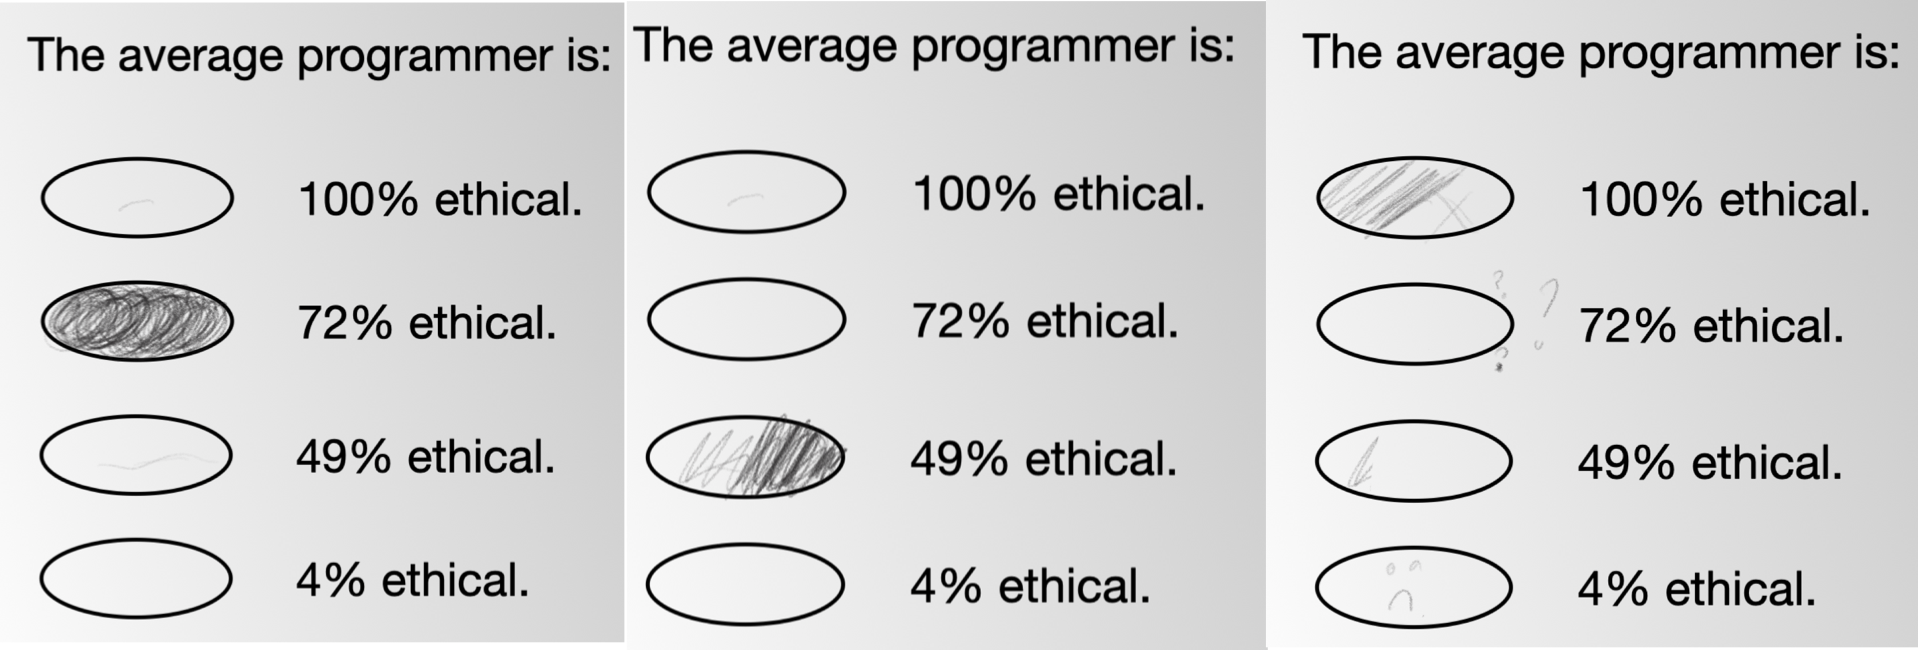

### Unfortunately...

Before you can begin work on this problem, your dataset is seized by the scantron Department of Sudden Random Efficiency and replaced by a "compressed" version. According to a DOSRE representative, storing entire scans of tests was a waste of precious bytes, and the only thing you really need is the ovals.

To further save space, the scans of the ovals themselves have been compressed into tiny, two-pixel, grayscale images, in which the values of the pixels range from 0 (for totally dark) to 255 (totally white). The left pixel represents the total average brightness of the left side of an oval and the right pixel represents the total average brightness of the right side of the oval.

See the figure below for an illustration of the DOSRE compression pipeline. The red boxes show the area of the oval represented by each pixel in the compressed version of the dataset. Note that although darker pixels tend to correspond to filled in ovals, there is considerable variety in the actual values. The reason is that factors such as the outline of the oval, stray marks, varied scanning conditions, etc. have a non-negligible impact on the final result, so pixels in the compressed data are unlikely to be entirely white or entirely dark.

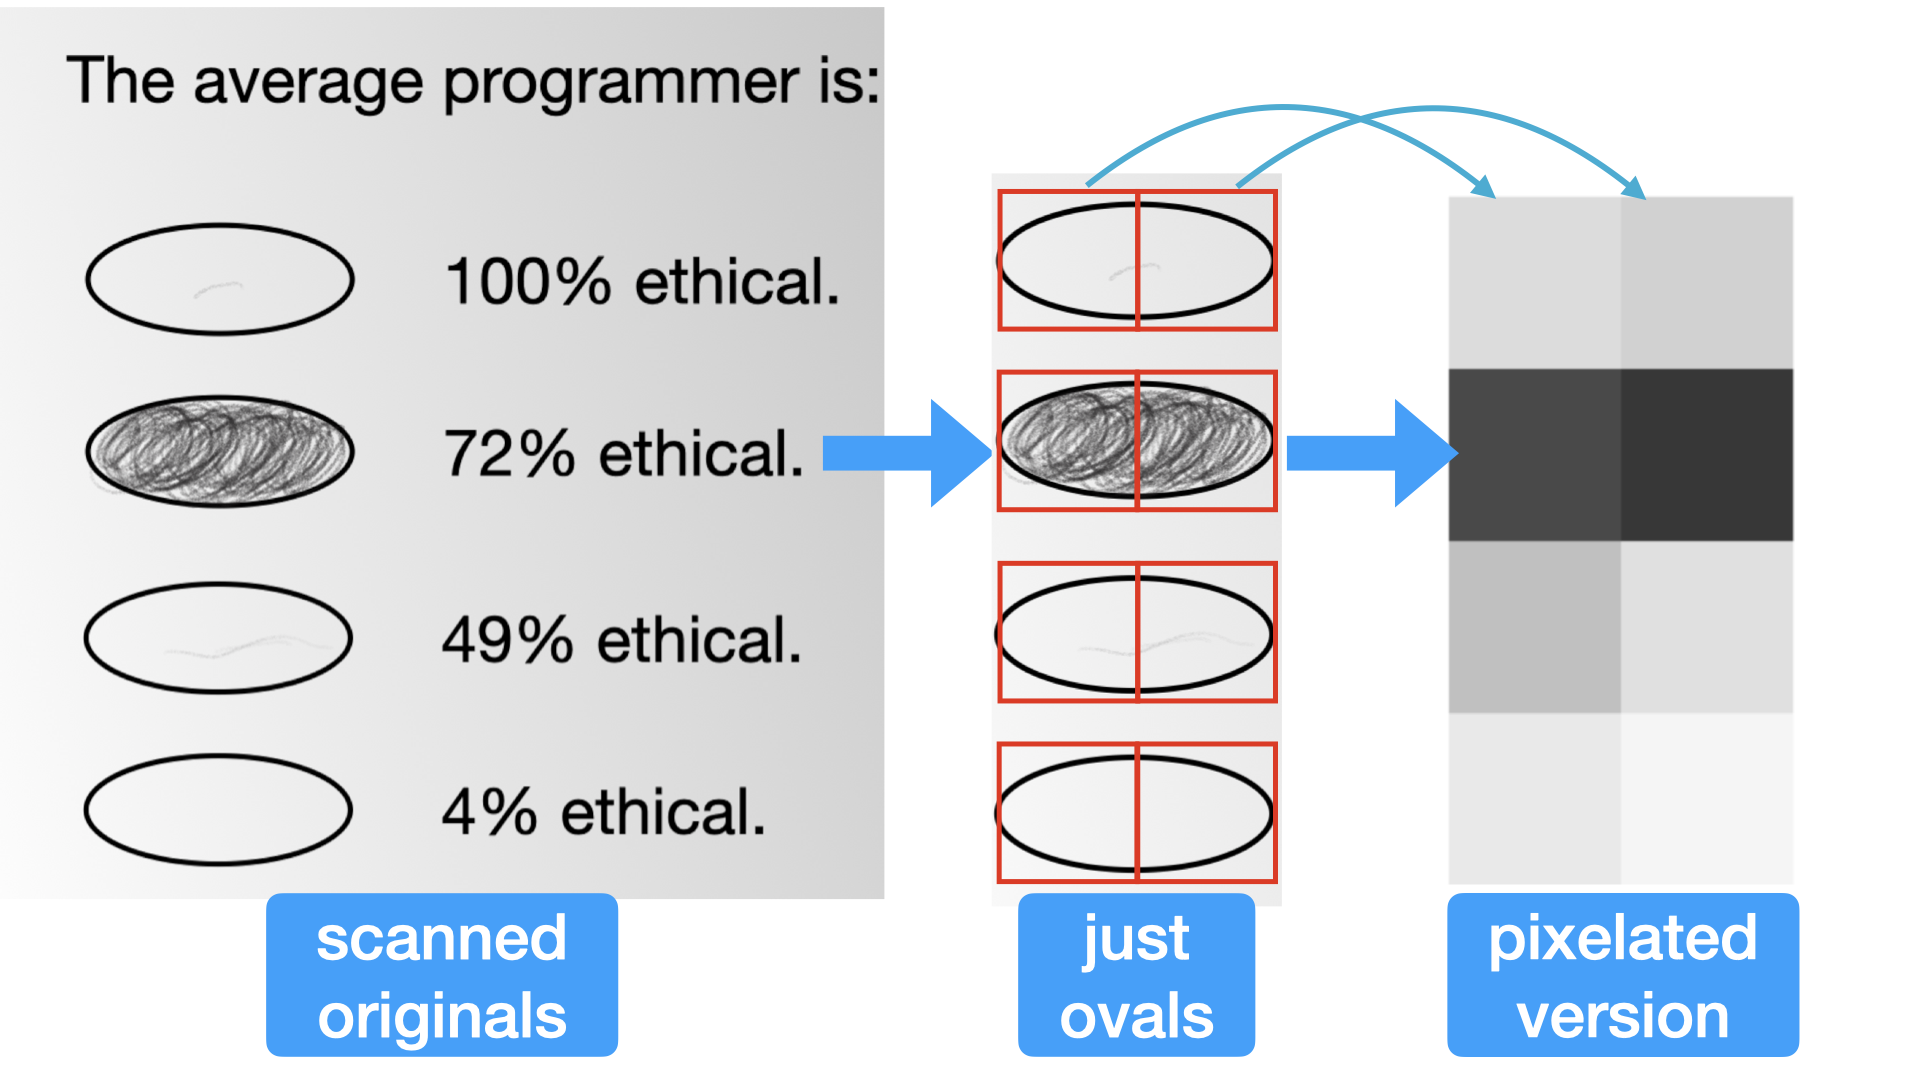

### Fortunately...
It's not your job to figure out which pixels correspond to which responses in the original tests. All you need to do is build a classifier that can take a two-pixel image and decide whether or not it corresponds to a filled-in oval or an unmarked oval.



## Part 1: Johnny Perceptron and the Super Lucky Data Set
Luckily for you, one of your colleagues managed to secure a labeled dataset that you can use to train your classifier. Run the code cell below to generate a plot of your training data.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

marked =  [(51, 177), (67, 152), (87, 187), (31, 174), (75, 181), (100, 82),
           (46, 188), (95, 232), (64, 122), (32, 137), (66, 134), (116, 220),
           (53, 107), (62, 212), (76, 180), (53, 118), (53, 134), (76, 136),
           (80, 169), (78, 229), (88, 160), (57, 113), (74, 117), (91, 220),
           (52, 204), (43, 237), (45, 133), (61, 223), (60, 113), (59, 171),
           (67, 124), (47, 158), (61, 237), (66, 132), (77, 186), (48, 137),
           (62, 186), (61, 226), (64, 167), (84, 188), (37, 188), (83, 137),
           (72, 203), (78, 144), (52, 188), (98, 133), (81, 172), (59, 113),
           (36, 173), (66, 161), (78, 150), (62, 187), (49, 147), (57, 115),
           (39, 195), (34, 147), (73, 103), (50, 164), (54, 138), (71, 103),
           (91, 130), (36, 152), (58, 183), (83, 163), (77, 143), (60, 227),
           (68, 85), (46, 220), (45, 223), (54, 145), (50, 188), (69, 180),
           (50, 145), (53, 164), (75, 164), (72, 178), (69, 139), (65, 145),
           (71, 186), (68, 179), (39, 87), (70, 190), (76, 246), (85, 177),
           (84, 125), (54, 122), (70, 155), (49, 176), (62, 64), (69, 203),
           (38, 142), (52, 111), (92, 129), (69, 153), (69, 190), (60, 201),
           (79, 131), (40, 168), (84, 116), (28, 107)]

unmarked =  [(146, 177), (140, 173), (181, 197), (189, 191), (148, 175),
             (208, 218), (205, 197), (220, 212), (177, 161), (163, 149),
             (146, 145), (184, 227), (166, 174), (213, 188), (207, 208),
             (159, 168), (163, 171), (218, 216), (164, 170), (189, 177),
             (166, 184), (199, 164), (145, 183), (221, 222), (142, 178),
             (148, 178), (214, 192), (184, 161), (162, 152), (163, 175),
             (194, 197), (145, 150), (155, 161), (172, 174), (163, 186),
             (180, 165), (189, 157), (196, 181), (155, 196), (165, 151),
             (201, 168), (190, 197), (193, 189), (203, 199), (209, 190),
             (155, 185), (185, 160), (143, 150), (202, 155), (167, 176),
             (196, 179), (185, 198), (164, 227), (216, 221), (126, 145),
             (156, 197), (185, 169), (187, 167), (164, 166), (187, 179),
             (204, 182), (148, 149), (179, 156), (202, 206), (167, 182),
             (213, 216), (198, 200), (165, 177), (158, 180), (186, 162),
             (159, 152), (145, 161), (162, 187), (195, 190), (160, 157),
             (167, 209), (202, 179), (191, 184), (169, 160), (205, 160),
             (193, 178), (129, 143), (160, 229), (172, 207), (186, 160),
             (201, 177), (144, 171), (188, 229), (161, 149), (182, 200),
             (176, 163), (194, 196), (216, 185), (203, 177), (141, 156),
             (173, 171), (165, 161), (190, 164), (174, 155), (157, 156)]

marked = np.array(marked)
unmarked = np.array(unmarked)
all_samples = marked + unmarked

x1_marked, x2_marked = zip(*marked)
x1_unmarked, x2_unmarked = zip(*unmarked)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x1_marked, x2_marked, label='Marked', marker='x', s=50)
plt.scatter(x1_unmarked, x2_unmarked, label='Unmarked', marker='o', s=50)

plt.xlim(0,255)
plt.ylim(0,255)
plt.xlabel("x1: left pixel brightness")
plt.ylabel("x2: right pixel brightness")
plt.title("Brightness of Compressed Oval Images")
plt.legend()
plt.grid(True)
plt.show()


### Finding unmarked ovals in three easy steps
Hooray! We got incredibly lucky and the data is arranged in nice linearly separable clusters. What a great opportunity to review our perceptron classifier. As you're recall, we just need to:
1. Define our classifier.
2. Train it on our data.
3. Check that it worked.

This should only take a minute.



#### Step 1: define the classifier
* The code from our previous exercise has been copied for you below, so just run the cell to define our perceptron class.

In [ ]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)

        self.errors_ = []

        for i in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    def __str__(self):
        return f"Perceptron(weights={self.w_}, bias={self.b_})"

#### Step 2: Train your perceptron:
* Just like you did before, run the cell below to fit our perceptron to our training data.


In [ ]:
# Note: to make training go faster we are scaling the pixel values here
marked = marked / 255
unmarked = unmarked / 255

y = np.array([0]*100 + [1]*100)
X = np.concatenate((marked, unmarked))

ppn = Perceptron(eta=1, n_iter=50)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.yticks(np.arange(0, max(ppn.errors_) + 1, 1))

plt.show()

#### A Note about Scaling:
If you were reading the code above carefully, you may have noticed there was actually a small difference in our training process: we are scaling the pixel values by dividing by 255. This transforms all our inputs into floats between 0 and 1, which helps the perceptron converge much more quickly. (The reason is beyond the scope of what we're covering, but if you're very curious and don't mind some math, you can check out the [Perceptron Convergence Theorem and proof](https://en.wikipedia.org/wiki/Perceptron#Convergence_of_one_perceptron_on_a_linearly_separable_dataset) given on the perceptron Wikipedia page.) On a conceptual level, you can safely ignore this adjustment since it doesn't change the distribution of the data.



#### Step 3: Check that it worked
* The graph above should show that our perceptron converges fairly quickly, but it's nice to also confirm visually when we can.
* To do this, let's plot the decision boundary like we did before.
* Note that the data is scaled now, and that is fine.

In [ ]:
# scaled points
x1_marked, x2_marked = zip(*marked)
x1_unmarked, x2_unmarked = zip(*unmarked)

plt.figure(figsize=(8, 6))
plt.scatter(x1_marked, x2_marked, label='Marked', marker='x', s=50)
plt.scatter(x1_unmarked, x2_unmarked, label='Unmarked', marker='o', s=50)

# Decision boundary
x_vals = np.array([0,1])
y_vals = -(ppn.w_[0] * x_vals + ppn.b_) / ppn.w_[1]
plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x1: left pixel brightness")
plt.ylabel("x2: right pixel brightness")
plt.title("Brightness of Compressed Oval Images")
plt.legend()
plt.grid(True)
plt.show()

### Task 1: Reflecting on our decision (boundary)
Now that your work is done, take a moment to ponder the decision boundary in the graph above. Recall the following takeaways from your previous work and our class discussions:
* The linear transformation that our perceptron applies to a given data point is $z = w_1x_1 + w_2x_2 + b$, where $x_1$ and $x_2$ are the features (or coordinates) of the given data point, and $w_1$, $w_2$ and $b$ are the constant weights and bias learned in the training process. The result, $z$ is called the "net input".
* The decision boundary corresponds to the line where net input goes from positive to negative.
* Equivalently, it shows where $z = 0$.
* Since $z = w_1x_1 + w_2x_2 + b$ is also the equation of a plane, you can think of the decision boundary geometrically as the intersection of the 2-dimensional plot shown above and the plane representing all possible values of $z$ for a given choice of weights $w_1$, $w_2$, and the bias $b$.
* The equation of the decision boundary can be expressed as $y = mx + b_y$, where $m$ is the slope and $b_y$ is the y-intercept (here the subscript $y$ is intended to distinguish $b_y$ from the perceptron's bias value).
* Further, the values of $m$ and $b$ are given by $m = -(w_1/w_2)$ and $b = -(b_y/w_2)$.

In view of the above, answer the following questions (for each answer, please briefly explain your reasoning):
* Q1. How many different choices of $w_1$, $w_2$ and $b$ could result in the same decision boundary?
* Q2. What determines how quickly the value of $z$ increases or decreases as the input moves away from the decision boundary?
* Q3. Is the perceptron's ultimate classification decision affected by the rate at which increasing the distance from the decision boundary increases or decreases the value of $z$?

Write you answers in the text cell below.

## Part 2: Disaster strikes
Oh no, your colleague made a mistake. The training data they sent you was missing a bunch of important data. Namely, it was supposed to have a hundred more 2-pixel images that also correlated to marked ovals.

That might not be too bad on its own, but unfortunately it seems likely that the missing points were statistically very different from the points that were previously included. Thus, the omission may have fundamentally misrepresented the nature (and difficulty) of the problem.

They have sent you the missing data so you can check. To investigate, run the cell below to add the new points (`also_marked`) to your previous graph.

In [ ]:
also_marked = [(139, 36), (174, 99), (168, 67), (142, 62), (199, 73),
               (255, 27), (130, 103), (168, 52), (179, 52), (208, 89),
               (212, 83), (191, 66), (190, 81), (192, 62), (230, 75),
               (165, 101), (229, 77), (172, 72), (167, 111), (181, 15),
               (210, 72), (164, 73), (175, 45), (162, 48), (180, 72),
               (171, 69), (178, 61), (178, 59), (187, 86), (215, 65),
               (183, 60), (187, 87), (186, 69), (255, 94), (182, 88),
               (210, 58), (173, 58), (193, 43), (190, 52), (165, 53),
               (178, 45), (218, 79), (136, 39), (159, 70), (170, 83),
               (182, 28), (182, 53), (215, 37), (241, 39), (153, 91),
               (184, 89), (149, 30), (136, 108), (184, 67), (233, 67),
               (202, 81), (207, 61), (219, 66), (201, 21), (209, 47),
               (180, 49), (186, 75), (206, 76), (211, 58), (178, 30),
               (156, 58), (188, 58), (247, 71), (165, 78), (201, 8),
               (226, 81), (174, 72), (148, 93), (180, 76), (143, 89),
               (147, 124), (159, 64), (158, 42), (206, 68), (207, 48),
               (182, 69), (223, 69), (156, 79), (152, 63), (189, 73),
               (208, 84), (167, 98), (133, 51), (218, 76), (159, 48),
               (186, 24), (244, 74), (150, 69), (169, 49), (186, 81),
               (176, 33), (183, 101), (160, 39), (120,70), (110,50)]

also_marked = np.array(also_marked)/255

x1_also_marked, x2_also_marked = zip(*also_marked)

plt.figure(figsize=(8, 6))
plt.scatter(x1_marked, x2_marked, label='Marked', marker='x', s=50)
plt.scatter(x1_also_marked, x2_also_marked, label='Also Marked', marker='x', color='red', s=50)
plt.scatter(x1_unmarked, x2_unmarked, label='Unmarked', marker='o', s=50)

# Decision boundary
x_vals = np.array([0,1])
y_vals = -(ppn.w_[0] * x_vals + ppn.b_) / ppn.w_[1]
plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x1: left pixel brightness")
plt.ylabel("x2: right pixel brightness")
plt.title("Brightness of Compressed Oval Images")
plt.legend()
plt.grid(True)
plt.show()

### Task 2: Analyze the new problem
* Q4. In your opinion, what is the biggest challenge posed by this new development in terms of completing your classification task?
* Q5. Is it still possible to classify our ovals based on the two features we've chosen? (Say why or why not.)


### Task 3: A Second Perceptron
Rather than redo your work or learn some fancy new classification model, you come up with a half-baked plan: just train a second perceptron on the newly added data.

Of course, this classifier won't work for the *entire* training set, but, you reason, you already have a classifier that works for the first part of the dataset. Maybe you can just ignore that part for now and figure out what to do about it later.

* Q6. Complete the code in the cell below to train a second perceptron that will distinguish between your original set of images corresponding to `unmarked` ovals and the new set of images you just received (corresponding to marked ovals). To be consistent with the code above, be sure you label the marked ovals 0 and the unmarked ovals 1.



In [ ]:
# Enter code here to define X and y

ppn2 = Perceptron(eta=1, n_iter=50)

ppn2.fit(X, y)

plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.yticks(np.arange(0, max(ppn2.errors_) + 1, 1))

plt.show()

Inspect the graph above to verify that your second perceptron is converging correctly to 0 updates. If all looks good, move on to question 7:
* Q7. Complete the code below as indicated in the comments to plot the decision boundary for your second perceptron back onto your original graph. Use a different color or line style to distinguish this second decision boundary from the first.

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x1_marked, x2_marked, label='Marked', marker='x', s=50)
plt.scatter(x1_also_marked, x2_also_marked, label='Also Marked', marker='x', color='red', s=50)
plt.scatter(x1_unmarked, x2_unmarked, label='Unmarked', marker='o', s=50)

# Decision boundary 1
x_vals = np.array([0,1])
y_vals = -(ppn.w_[0] * x_vals + ppn.b_) / ppn.w_[1]
plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary 1')

# Enter code here to plot Decision boundary 2

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x1: left pixel brightness")
plt.ylabel("x2: right pixel brightness")
plt.title("Brightness of Compressed Oval Images")
plt.legend()
plt.grid(True)
plt.show()

### Task 4: Assessing our progress
Now that we have two classifiers for different subsets of our training data, it's a good time to take a step back and look at the whole picture.

* Q8. Examine the graph above and take a moment to note down any salient features. Are the decision boundaries drawn where you expected them to be? Does anything stand out as notable or puzzling? (This question is intentionally open-ended and there is no single correct answer.)

* Q9. Complete the code in the cell below as indicated in the comments to determine exactly how many of the total data points each classifier is classifying correctly.


In [ ]:
# Combine our two subsets of marked oval data into one set
all_marked = np.concatenate((marked, also_marked))

# Use the predict method of your first perceptron to determine how many of the
# images of marked ovals it classifies correctly vs. how many it classifies
# incorrectly


# Now determine how many of the images of unmarked ovals the first perceptron
# classifies correctly vs. how many it classifies incorrectly

# Repeat the above for the second perceptron.


* Q10. Use your solution in the cell above to answer the following four questions for both perceptron 1 and 2:
  * A. How many of the unmarked ovals does it correctly classify as unmarked ovals?
  * B. How many of the unmarked ovals does it incorrectly classify as marked ovals?
  * C. How many of the marked ovals does it correctly classify as marked ovals?
  * D. How many of the marked ovals does it incorrectly classify as unmarked ovals?

* Q11. Referring to your answers above, is there anything both perceptrons have in common?
* Q12. Recall that our perceptrons work by transforming the input features into some $z$ value, and making a classification decision depending on whether $z$ is positive. Assuming you were trying to classify a data point and were given only the two $z$ values produced by the two perceptrons for that point, how could you use this information to always arrive at a correct classification decision? (You may find it helpful to look back at the graph showing both decision boundaries.)


## Part 3: A New Hope
The story so far:
* We have two classifiers, each of which works for a portion of our training data, but neither of which can correctly classify the entire data set.
* We would like to somehow combine them into a complete solution.

### Our approach: features -> perceptrons -> new features
* One way we might combine the information provided by our two partial solutions is by treating the predictions they each produce as "features" in their own right.
* In other words, we could use each perceptron's classification decision or "opinion" about a given data point as a feature that captures something about that data point.
* The combined list of the output for all perceptrons then becomes a new feature vector for each data point.
* Taken together, these vectors form a new, aggregate representation of the data.
* The hope is that this new representation might make our classification task easier to accomplish (and in this case we have seen some evidence already that this might be the case).

### `sigmoid`: representing perceptron predictions and confidence
The explanation above is missing an important detail: what do we use to capture a perceptron's classification decision? There are many possible ways we could go about this.
* The simplest approach might be to just use the prediction label. However, this would result in a purely binary output, and it doesn't give us any way to distinguish between points that were very close to a decision boundary (which might represent less confidence) and points that were far away.
* It would be nice to get both the prediction and some indication of how confident the classifier is about the prediction.
* In our example, we would also like the output to be somewhere between 0 and 1, to save us the trouble of scaling it again.

One function out of many that accomplishes these goals is the `sigmoid` function. Its exact definition is provided for you in the code cell below, but its intuitive description is arguably more important than the technical details:
* it takes as input any $z$ value (which could be very largely or very negative) and squishes it into a score between 0 and 1.
* The result is greater that 0.5 when $z$ is positive and less that 0.5 otherwise.
* Very large values of $z$ end up close to 1, whereas very negative values end up close to 0.

### Task 5: Putting our Two Braincells Together
* Q13. Complete the code cell below as indicated in the comments to produce a 2d scatter plot of our dataset. The horizontal axis should represent the output of the sigmoid function applied to the net input ($z$) of the first perceptron, and the vertical output should be the output of the sigmoid function applied to the net input ($z$) of the second perceptron.

In [ ]:
def sigmoid(z):
    """Apply the sigmoid function to the net input z.
       input: z, the net input, can be a single value or an np array
       output: the transformed z (either a single value or an array,
       depending on the input)
    """
    return 1/(1 + np.exp(-z))

# Add code below these comments to do the following:
# 1. Use the net_input method of each trained perceptron to produce z values
# for all images corresponding to marked ovals.
# 2. Apply the sigmoid function to the z values to get the squashed values.
# 3. Store the results for perceptron 1 in p1_marked and the results for
# perceptron 2 in p2_marked.
# 4. Repeat the above for unmarked ovals and store the results in p1_unmarked
# and p2_unmarked, respectively.


plt.figure(figsize=(8, 6))
plt.scatter(p1_marked, p2_marked, label='marked', marker='x', s=50)
plt.scatter(p1_unmarked, p2_unmarked, label='unmarked', marker='o', s=50)


plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("sigmoid(z1): first perceptron")
plt.ylabel("sigmoid(z2): second perceptron")
plt.title("Sigmoid of Net Input from perceptrons 1 and 2")
plt.legend()
plt.grid(True)
plt.show()


### Task 6: A Little Neuronsurgery
The data above is almost linearly separable, but not quite. It would be very convenient if the net input functions of our perceptrons could keep the same decision boundary, but assign higher positive scores to points on the positive side and more negative scores to points on the negative side.
* Q14: Refer back to your responses to Task 1 for hints about how you might accomplish this, then use the code cell below to "manually" adjust your perceptrons as needed.  
* Q15: After you've made your changes to perceptrons 1 and 2, rerun the preceding cell to re-draw the plot of the data and verify that it is now linearly separable.  


In [ ]:
# Use this code cell to make tweaks to your perceptrons until the clusters in the
# plot above become linearly separable. Be careful not to change the decision
# boundaries!



### Task 7: One perceptron to rule them all
* Q16. Once you are confident that the data is linearly separable, complete the code cell below to create a 3rd perceptron and train it on the second-order features we created from perceptrons 1 and 2.

In [ ]:
# Complete the lines below to set up the X and y values you'll use to train
# your final perceptron.

ppn3 = Perceptron(eta=1, n_iter=50)

ppn3.fit(X, y)

plt.plot(range(1, len(ppn3.errors_) + 1), ppn3.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.yticks(np.arange(0, max(ppn.errors_) + 1, 1))

plt.show()

* Q17: Check the plot above to make sure your perceptron is converging. Then complete the code cell below to reproduce the plot from Q13 and add the decision boundary corresponding to the trained third perceptron.

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(p1_marked, p2_marked, label='marked', marker='x', s=50)
plt.scatter(p1_unmarked, p2_unmarked, label='unmarked', marker='o', s=50)

# Add code for your decision boundary here


plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("sigmoid(z1): first perceptron")
plt.ylabel("sigmoid(z2): second perceptron")
plt.title("Sigmoid of Net Input from perceptrons 1 and 2")
plt.legend()
plt.grid(True)
plt.show()

### Task 8: Summing Up
The goal of this assignment was to help you get an intuitive feel for what a small neural network might be doing, so you can apply this to understanding the behavior of the much larger networks that are used for many tasks associated with the term "AI."

A secondary goal is to help provide some context for the oft-repeated claim that neural networks "automatically learn their own features."

Of course, many of the steps taken to get us to our end result relied on human intervention and judgement. When we move on to **back propagation** you'll get exposure to a more systematic method of finding a working set of weights---one that can be applied on a massive scale.

There were also a few major moments that relied strongly on "luck" (or your instructor stacking the deck in your favor). To be clear: you should not always expect to be able to solve an arbitrary classification problem with 3 neurons, or by building your network one block at a time.

* Q18. Identify at least 2 places where our approach might not have worked for different data.
* Q19. To help further your intuition for a more "realistic" (though still very small) neural network, spend some time experimenting with [Tensor Flow's online Neural Network Playground](https://playground.tensorflow.org/). Describe the simplest network configuration you can find that is capable of fitting the spiral dataset with a training loss of 0. Say what features you used, how many hidden layers, how many neurons at each layer, and any other tricks you found helpful.


## Submitting your Notebook
The process for submitting this assignment is the same as assignment 1. For convenience, here is a reminder:

### Step 1: Check for completion
**This assignment will be graded based on completion. To get credit, it must be complete!** This means you must:
* Run all the code cells.
* Complete all the tasks and exercises.
* Answer all the questions.

Take a moment now to look back over your notebook and check that it's ready to submit.


### Step 2: Move your notebook to your assignment submission folder
You submit your notebook by moving it to your assignment submission folder, a Google Drive folder that has been shared with you for this purpose.
* The name of your assignment submission folder is `csci375-submit-here-<your_obieID>`, where `<your_obieID>` should be replaced with your personal ObieID.
* For example, if your ObieID is `mzucker`, your assignment submission folder would be called `csci375-submit-here-mzucker`.
* You should be able to find this folder by searching in Google Drive, or looking under the "Shared with me" section.
* To avoid chaos, first please double check that you have renamed your notebook file to append your obieID to the filename.
* When you are ready to submit, locate your copy of this file in your Google Drive, and move it into your assignment submission folder.

Note that you will still be able to edit your file even after it is shared. However, after the submission deadline has passed a copy of your submission will be made for grading, and will not be able to receive any further edits.

Go forth!

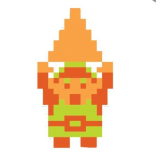